# Summarize the reviews

The idea in this solution is to provide a new feature to the customer which will reduce the need to go through several reviews in order to evaluate a product. In order to achieve that, we will attempt to extract the most predictive words or sentences from the ratings and present them in a nice format (e.g. wordcloud).

## Implementation steps of a proof of concept

- Extract the summaries and split them to words
- Keep only the data with ranks 1, 2 -labeled as 0- and 5 -labeled as 1. 
- Generate tf-idf vector features from the words
- Train a binary logistic regression model which predicts the rankings from the vector features
- Using this model evaluate each word by generating the features for  it as if it were a whole summary
- Order the words by the probability generated by the model to be in the '0' or '1' category
- Select the words with highest probability to be '1' as the positive ones
- Select the words with highest probability to be '0' as the negative ones
- Pick a random set of products and print the top 10 words with highest probabilities (max of positive and negative) on a wordcloud

## Loading and preparing the data

In [89]:
all_reviews = (spark
    .read
    .json('./data/raw_data/reviews_Amazon_Instant_Video_5.json.gz',)
    .na
    .fill({ 'reviewerName': 'Unknown' }))

In [90]:
from pyspark.sql.functions import col, expr, udf, trim
from pyspark.sql.types import IntegerType
import re

remove_punctuation = udf(lambda line: re.sub('[^A-Za-z\s]', '', line))
make_binary = udf(lambda rating: 0 if rating in [1, 2] else 1, IntegerType())

reviews = (all_reviews
    .filter(col('overall').isin([1, 2, 5]))
    .withColumn('label', make_binary(col('overall')))
    .select(col('label').cast('int'), remove_punctuation('summary').alias('summary'))
    .filter(trim(col('summary')) != ''))

## Splitting data and balancing skewness

In [91]:
train, test = reviews.randomSplit([.8, .2], seed=5436L)

In [92]:
def multiply_dataset(dataset, n):
    return dataset if n == 1 else dataset.union(multiply_dataset(dataset, n - 1))

In [93]:
reviews_bad = train.filter('label == 0')
reviews_bad_multiplied = multiply_dataset(reviews_bad, reviews_good.count() / reviews_bad.count())

reviews_good = train.filter('label == 1')

train_reviews = reviews_bad_multiplied.union(reviews_good)

## Benchmark: predict by distribution

In [94]:
accuracy = reviews_bad_multiplied.count() / float(train_reviews.count())
print('Always predicting 5 stars accuracy: {0}'.format(accuracy))

Always predicting 5 stars accuracy: 0.458889782784


## Learning pipeline

In [95]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

tokenizer = Tokenizer(inputCol='summary', outputCol='words')
hashing_tf = HashingTF(inputCol='words', outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures', outputCol='features')
log_regression = LogisticRegression()

pipeline = Pipeline(stages=[
    tokenizer, 
    hashing_tf,
    idf,
    log_regression
])

paramGrid = (ParamGridBuilder()
    .addGrid(hashing_tf.numFeatures, [120000])
    .addGrid(log_regression.regParam, [.3])
    .addGrid(log_regression.elasticNetParam, [.01])
    .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

## Testing the model accuracy

In [96]:
model = crossval.fit(train_reviews)
model.avgMetrics

[0.9584946801236659]

In [97]:
prediction = model.transform(test)
BinaryClassificationEvaluator().evaluate(prediction)

0.9177994722256233

## Using model to extract the most predictive words

In [98]:
from pyspark.sql.functions import explode
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType

words = (tokenizer
    .transform(reviews)
    .select(explode(col('words')).alias('summary')))

predictors = (model
    .transform(words)
    .select(col('summary').alias('word'), 'probability'))

first = udf(lambda x: x[0].item(), FloatType())
second = udf(lambda x: x[1].item(), FloatType())

predictive_words = (predictors
   .select(
       'word', 
       second(col('probability')).alias('positive'), 
       first(col('probability')).alias('negative'))
   .groupBy('word')
   .agg(
       F.max('positive').alias('positive'),
       F.max('negative').alias('negative')))

positive_predictive_words = (predictive_words
    .select(col('word').alias('positive_word'), col('positive').alias('pos_prob'))
    .sort('pos_prob', ascending=False))

negative_predictive_words = (predictive_words
    .select(col('word').alias('negative_word'), col('negative').alias('neg_prob'))
    .sort('neg_prob', ascending=False))

In [99]:
import pandas as pd

pd.concat([
    positive_predictive_words.toPandas().head(n=20),
    negative_predictive_words.toPandas().head(n=20) ],
    axis=1)

,positive_word,pos_prob,negative_word,neg_prob
0,five,0.727101,meh,0.659010
1,excellent,0.720200,disappointing,0.657519
2,hilarious,0.717501,unwatchable,0.650674
3,lie,0.716981,mediocre,0.649736
4,awesome,0.716950,boring,0.647683
5,enjoyable,0.713686,theyd,0.645040
6,disappoint,0.710817,eh,0.644162
7,brilliant,0.710591,charges,0.644162
8,customers,0.710591,sucked,0.642412
9,outstanding,0.708043,worst,0.640435


## Summarize single product - picks the best and worst

In [275]:
full_model = crossval.fit(reviews)

In [267]:
highly_reviewed_products = (all_reviews
    .groupBy('asin')
    .agg(F.count('asin').alias('count'), F.avg('overall').alias('avg_rating'))
    .filter('count > 25'))

In [274]:
best_product = highly_reviewed_products.sort('avg_rating', ascending=False).take(1)[0][0]

worst_product = highly_reviewed_products.sort('avg_rating').take(1)[0][0]

In [285]:
def most_contributing_summaries(product, total_reviews, ranking_model):
    reviews = total_reviews.filter(col('asin') == product).select('summary', 'overall')
    
    udf_max = udf(lambda p: max(p.tolist()), FloatType())
    
    summary_ranks = (ranking_model
        .transform(reviews)
        .select(
            'summary', 
            second(col('probability')).alias('pos_prob')))
    
    pos_summaries = { row[0]: row[1] for row in summary_ranks.sort('pos_prob', ascending=False).take(10) }
    neg_summaries = { row[0]: row[1] for row in summary_ranks.sort('pos_prob').take(10) }
    
    return pos_summaries, neg_summaries

In [326]:
from wordcloud import WordCloud

def present_product(product, total_reviews, ranking_model):
    pos_summaries, neg_summaries = most_contributing_summaries(product, total_reviews, ranking_model)
    
    pos_wordcloud = WordCloud(max_words=20).fit_words(pos_summaries)
    neg_wordcloud = WordCloud(max_words=20).fit_words(neg_summaries)
    
    fig = plt.figure(figsize=(15, 15))
    
    ax = fig.add_subplot(1,2,1)
    ax.set_title('Positive summaries')
    ax.imshow(pos_wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title('Negative summaries')
    ax.imshow(neg_wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    plt.show()

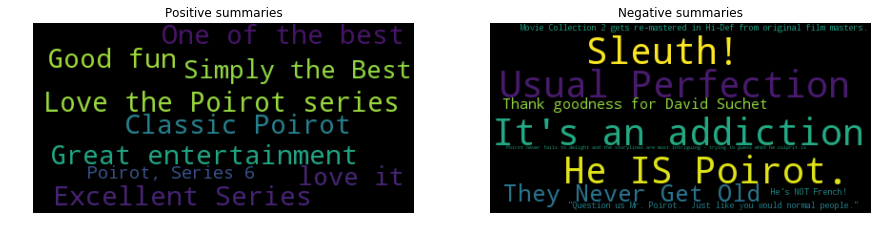

In [327]:
present_product(best_product, all_reviews, full_model)

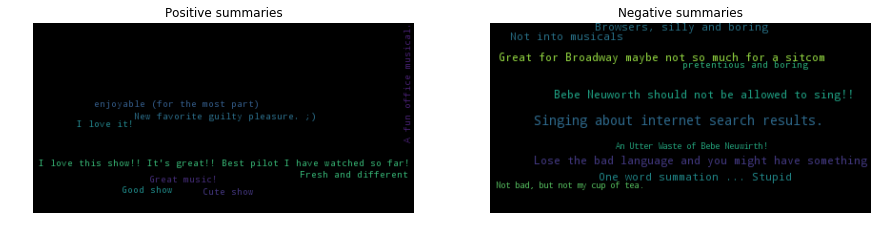

In [328]:
present_product(worst_product, all_reviews, full_model)